# Домашнее задание 5. Линейные модели

In [1]:
%matplotlib inline
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import sklearn.metrics as sm
from collections import defaultdict
import random
from scipy.special import expit
from sklearn.model_selection import train_test_split
import sklearn.linear_model

Зачитываем результат 4 домашки

In [100]:
data = np.load("out_4.npz")
users = data["users"].astype(np.int64)
X_dataset = data["data"].reshape(1,)[0]

In [65]:
X_dataset.shape

(11947, 201885)

Зачитываем категории пользователей

In [101]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

In [6]:
df_users.shape

(11947, 2)

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [68]:
users

array([ 871169502,   48520595,  326956063, ..., 2395498116, 2295079410,
       1908456235])

In [107]:
train_users_list = df_users_train['uid'].values
train_mask = np.in1d(users, train_users_list)
X = X_dataset[np.where(train_mask)]
Xid = users[np.where(train_mask)]

In [108]:
res_users_list = df_users_ex['uid'].values
res_mask = np.in1d(users, res_users_list)
resX = X_dataset[np.where(res_mask)]
resXid = users[np.where(res_mask)]

In [103]:
testsub = pd.read_csv('test_submission.csv', sep=",", header=0)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [109]:
Y = np.array([df_users_train[df_users_train['uid'] == uid]['cls'].values[0] for uid in Xid])

In [111]:
Y.shape

(7199,)

Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

In [110]:
X.shape

(7199, 201885)

In [113]:
freqs = defaultdict(int)
for user in X:
    user_words = len(user.data)
    freqs[user_words] += 1

fslist = [(s, freqs[s]) for s in freqs]
sumslist = list(zip(*fslist)[0])
freqslist = list(zip(*fslist)[1])

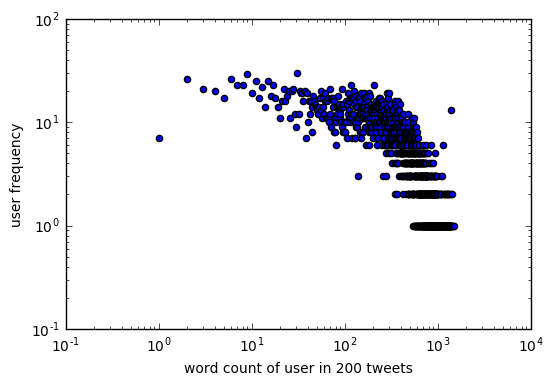

In [114]:
pl.figure()
ax = pl.gca()
ax.set_yscale('log')
ax.set_xscale('log')
pl.xlabel('word count of user in 200 tweets')
pl.ylabel('user frequency')
pl.scatter(sumslist[1:], freqslist[1:])

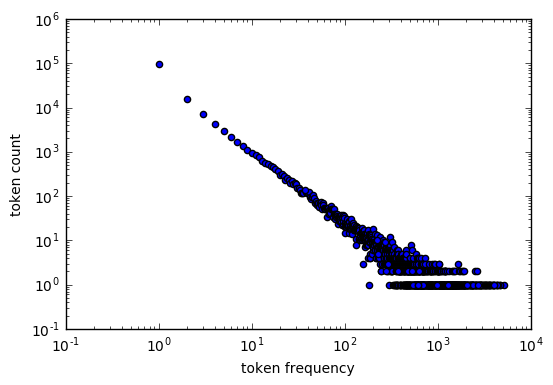

In [115]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    freqs = defaultdict(int)
    feature_counts = np.empty(x.shape[1])
    for i, word in enumerate(x.T):
        word_freq = len(word.data)
        feature_counts[i] = word_freq
        freqs[word_freq] += 1
        
    fslist = [(s, freqs[s]) for s in freqs]
    wordfreqslist = list(zip(*fslist)[0])
    freqscountlist = list(zip(*fslist)[1])
    
    pl.figure()
    ax = pl.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    pl.xlabel('token frequency')
    pl.ylabel('token count')
    pl.scatter(wordfreqslist[1:], freqscountlist[1:])
#     print(wordfreqslist[0], freqscountlist[0])
    
    return feature_counts

feature_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [121]:
X = X.tocsc()[:, feature_counts > 100].toarray()


AttributeError: 'numpy.ndarray' object has no attribute 'tocsc'

In [122]:
resX = resX.tocsc()[:, feature_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [117]:
USER_NAME = "l.aleksandr"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


In [118]:
def auroc(res, Y):
    thresspace = np.linspace(1, 0, num = 51)
    tpr = [np.mean((res[:, 1] > thr) & (Y == 1)) / np.mean(Y == 1) for thr in thresspace]
    fpr = [np.mean((res[:, 1] > thr) & (Y == 0)) / np.mean(Y == 0) for thr in thresspace]
    area = np.trapz(y = tpr, x = fpr)
    return tpr, fpr, area

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)
lr = sklearn.linear_model.LogisticRegression(penalty='l1', C = 1, tol = 0.001, max_iter = 1000).fit(X_train, Y_train)
# lr = sklearn.linear_model.LogisticRegression().fit(X_train, Y_train)
probs = lr.predict_proba(X_test)
print(auroc(probs, Y_test)[2])

0.562146476473


In [133]:
cheatlr = sklearn.linear_model.LogisticRegression(penalty='l1', C = 1, tol = 0.001, max_iter = 1000).fit(X, Y)
probs = zip(*cheatlr.predict_proba(resX))[1]

In [128]:
resXid

array([ 871169502,  435231062, 2742685950, ...,  569635263, 2395498116,
       2295079410])

In [144]:
probs[np.where(resXid == 783836768)[0][0]]

0.67592147049247442

In [149]:
testsub['newcls'] = testsub['uid'].map(lambda x: probs[np.where(resXid == x)[0][0]] if len(np.where(resXid == x)[0]) == 1 else None)

In [157]:
testsub.newcls.fillna(testsub.cls, inplace=True)

In [164]:
testsub = testsub[['uid', 'cls']]

In [166]:
testsub.to_csv('results.csv', sep =',', index=False)

In [96]:
result = np.concatenate((np.asarray(resXid, dtype=int).reshape(-1, 1),  np.asarray(res, dtype=float).reshape(-1, 1)), axis=1)
np.savetxt('results.csv', result, fmt = '%d,%f', header='uid,cls', comments='')

In [286]:
# just testing the dataset to see if the standard classifier does its work. It doesn't
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
clist = [0.01, 0.1, 1, 10, 100, 1000, 10000]
best_value = 0
best_c = 0
for c in clist:
    probs = sklearn.linear_model.LogisticRegression(penalty='l1', C = c).fit(X_train, Y_train).predict_proba(X_test)
    tpr, fpr, value = auroc(probs, Y_test)
    print(value)
    if value > best_value:
        best_value = value
        best_c = c
print(best_c, best_value)

0.479507880737
0.496480928726
0.507192342853
0.535978235728
0.524914363759
0.521554999945
0.524352634072
(10, 0.53597823572821091)


Реализуем выбранный алгоритм

In [27]:
class LogisticRegression():
    h = lambda self, elem: expit(self.theta[0] + np.dot(elem, self.theta[1:]))
    
    def fit(self, X, Y, alpha, c, iters):
        self.theta = np.zeros(X.shape[1] + 1)
        for it in xrange(50):
            orig_theta = np.copy(self.theta)
            i = random.randint(0, X.shape[0] - 1)
            self.theta[0] -= alpha * ((self.h(X[i]) - Y[i]) + c / X.shape[0] * (sum(abs(self.theta[1:]))))
            self.theta[1:] -= alpha * ((self.h(X[i]) - Y[i]) * X[i] + c / X.shape[0] * (sum(abs(self.theta[1:]))))
        return self
    
    def predict_proba(self, X):
#         print(self.theta)
        res = self.h(X)
        return np.array(zip(*(1 - res, res)))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
probs = LogisticRegression().fit(X_train, Y_train, 0.00005, 0.1, 50).predict_proba(X_test)
tpr, fpr, value = auroc(probs, Y_test)

0.297552331082
0.226412796554
0.286746480714
0.185450641598
0.263299104767
0.199643644331
0.296834953657
0.256297094841
0.214371947327
0.195860013003
0.196768749405
0.244713060835
0.264721192661
0.217824020655
0.158921788056
0.226952331456
0.132847897912
0.178227729506
0.250025352751
0.19840964128
0.16450420379
0.213181601675
0.171144531278
0.140292955203
0.193297647226
0.206498430553
0.148925473314
0.174679019506
0.184825712255
0.178209100259
0.11317890749
0.169767087374
0.195891831063
0.115690225991
0.137183010612
0.194514152056
0.12207992193
0.195455848616
0.205602956683
0.107987378808
0.147725671773
0.172168975918
0.146321829657
0.246623265012
0.161553467094
0.154709316948
0.14542780762
0.127292639911
0.191069930749
0.0974856446973


In [202]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
clist = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
alphalist = np.linspace(0.00001, 0.001, num = 11)
# alphalist = [0.0005]
best_value = 0
best_c = 0
best_alpha = 0
iters = 500
for C in clist:
    for alpha in alphalist:
        probs = LogisticRegression().fit(X_train, Y_train, alpha, C, iters).predict_proba(X_test)
        tpr, fpr, value = auroc(probs, Y_test)
        print(value)
        if value > best_value:
            best_value = value
            best_c = C
            best_alpha = alpha
print(best_alpha, best_c, best_value)

0.480859355102
0.497312923437
0.52053512302
0.538223982477
0.528303448627
0.503591258723
0.509392033009
0.547628750446
0.548596607407
0.53115607967
0.531824665071
0.495561866436
0.502897203403
0.497879629158
0.53095868779
0.490697111711
0.515090927614
0.501286230961
0.507449951607
0.50000636748
0.495294432275
0.512180989252
0.488239264429
0.502502419642
0.52059243034
0.501617339922
0.499363251999
0.491314757272
0.497503947838
0.513524527533
0.493053079313
0.511200397331
0.538032958077
0.482470327543
0.484004890225
0.49959884876
0.501369008201
0.513499057613
0.520286791299
0.517574244817
0.523075747542
0.521413835261
0.488220161989
0.532531455351
0.488322041669
0.476828740258
0.502362335082
0.504686465284
0.49984718048
0.47911466558
0.519516326219
0.500630380521
0.50990143141
0.523126687382
0.526667006266
0.493072181753
0.525374407824
0.499013040599
0.501630074882
0.518529366818
0.533155468392
0.512505730732
0.575581987673
0.535689725434
0.504686465284
0.524298303703
0.474752941776
0.51

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in double_scalars


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.514374


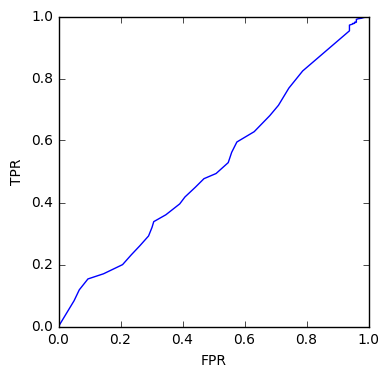

In [203]:
def classify(X, Y, test_size_param, alpha_param, C_param, iters_param):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size_param)
    probs = LogisticRegression().fit(X_train, Y_train, alpha_param, C_param, iters_param).predict_proba(X_test)
    tpr, fpr, roc_auc = auroc(probs, Y_test)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X, Y, 0.1, best_alpha, best_c, iters)

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    pl.figure(figsize = (4, 4))
    pl.plot(fpr, tpr)
    pl.xlabel('FPR')
    pl.ylabel('TPR')

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.